In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import plotly.express as px
from scipy import signal
import statsmodels.api as sm
from matplotlib import pyplot as plt

#from fredget import fredget

df_m = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/monthly/current.csv',parse_dates=True, index_col=1)
# df_q = pd.read_csv('https://files.stlouisfed.org/files/htdocs/fred-md/quarterly/current.csv',parse_dates=True, index_col=1)
df_m.to_csv('tester.csv')


In [5]:
def transform(column, transforms,dfreq):
    transformation = transforms[column.name]
    # For quarterly data like GDP, we will compute
    # annualized percent changes
    mult = 4 if dfreq == 'Q' else 1

    # 1 => No transformation
    if transformation == 1:
        pass
    # 2 => First difference
    elif transformation == 2:
        column = column.diff()
    # 3 => Second difference
    elif transformation == 3:
        column = column.diff().diff()
    # 4 => Log
    elif transformation == 4:
        column = np.log(column)
    # 5 => Log first difference, multiplied by 100
    #      (i.e. approximate percent change)
    #      with optional multiplier for annualization
    elif transformation == 5:
        column = np.log(column).diff() * 100 * mult
    # 6 => Log second difference, multiplied by 100
    #      with optional multiplier for annualization
    elif transformation == 6:
        column = np.log(column).diff().diff() * 100 * mult
    # 7 => Exact percent change, multiplied by 100
    #      with optional annualization
    elif transformation == 7:
        column = ((column / column.shift(1))**mult - 1.0) * 100
        
    return column


In [3]:
def load_fredmd_data(vintage):
    base_url = 'https://files.stlouisfed.org/files/htdocs/fred-md'
    
    # - FRED-MD --------------------------------------------------------------
    # 1. Download data
    orig_m = (pd.read_csv(f'{base_url}/monthly/{vintage}.csv')
                .dropna(how='all'))
    
    # 2. Extract transformation information
    transform_m = orig_m.iloc[0, 1:]
    orig_m = orig_m.iloc[1:]

    # # 3. Extract the date as an index
    # orig_m.index = pd.PeriodIndex(orig_m.sasdate.tolist(), freq='M')
    # orig_m.drop('sasdate', axis=1, inplace=True)
    orig_m['sasdate'] = pd.to_datetime(orig_m['sasdate'],format='%m/%d/%Y')
    orig_m.set_index('sasdate',inplace=True)
    #orig_m.drop('sasdate', axis=1, inplace=True)
   

    #4. Apply the transformations
    dta_m = orig_m.apply(transform, axis=0,
                         transforms=transform_m,dfreq ='M')

  

    # - FRED-QD --------------------------------------------------------------
    # 1. Download data
    orig_q = (pd.read_csv(f'{base_url}/quarterly/{vintage}.csv')
                .dropna(how='all'))

    # 2. Extract factors and transformation information
    factors_q = orig_q.iloc[0, 1:]
    transform_q = orig_q.iloc[1, 1:]
    orig_q = orig_q.iloc[2:]

    # 3. Extract the date as an index
    # orig_q.index = pd.PeriodIndex(orig_q.sasdate.tolist(), freq='Q')
    # orig_q.drop('sasdate', axis=1, inplace=True)
    orig_q['sasdate'] = pd.to_datetime(orig_q['sasdate'],format='%m/%d/%Y')
    orig_q.set_index('sasdate',inplace=True)

    # 4. Apply the transformations
    dta_q = orig_q.apply(transform, axis=0,
                          transforms=transform_q,dfreq ='Q')


    # - Output datasets ------------------------------------------------------
    return dta_m,dta_q

In [6]:
df,transf = load_fredmd_data('2023-02')
df.head()
# df = pd.merge(dfm, dfq, left_index=True, right_index=True)


,RPI,W875RX1,DPCERA3M086SBEA,CMRMTSPLx,RETAILx,INDPRO,IPFPNSS,IPFINAL,IPCONGD,IPDCONGD,...,DNDGRG3M086SBEA,DSERRG3M086SBEA,CES0600000008,CES2000000008,CES3000000008,UMCSENTx,DTCOLNVHFNM,DTCTHFNM,INVEST,VIXCLSx
sasdate,,,,,,,,,,,,,,,,,,,,,
1959-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-02-01,0.393140,0.361286,1.036756,0.735762,0.730985,1.939721,1.340638,0.862332,0.730905,0.523616,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1959-03-01,0.643011,0.735934,0.941009,-0.342293,0.832120,1.430052,0.603299,0.489949,0.000000,1.939106,...,-0.112407,0.026180,-0.002184,-0.814665,0.481883,NaN,0.492915,0.413844,-1.479236,NaN
1959-04-01,0.649412,0.704864,-0.363947,1.992210,0.061571,2.108095,1.433652,1.454298,1.565485,0.638102,...,0.134899,0.175237,-0.002163,1.220345,-0.488953,NaN,1.213403,0.673430,2.492924,NaN
1959-05-01,0.576311,0.661646,1.200535,0.679731,0.780340,1.495129,0.827073,0.958345,0.476609,2.015394,...,-0.168653,-0.193673,-0.002143,-0.408972,-0.481929,NaN,0.282830,0.202040,-1.534223,NaN


In [11]:
import math 
glob_list = list(df.columns.values)
reglist = list()

df_reg = df
target = 'INDPRO'

for f in glob_list:
    for i in range(1,23):
        varname = f'{f}_L_{i}'
        reglist.append(varname)
        df_reg[varname] = df_reg[f].shift(i) 


df_model = df_reg.loc['1995-1-1':'201-1-1']

x = df_model[reglist]
y = df_model[target]
#print(reglist)

'''XGBOOST BEGINS HERE'''
regressor = xgb.XGBRegressor(
    n_estimators=50,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)
regressor.fit(x, y)



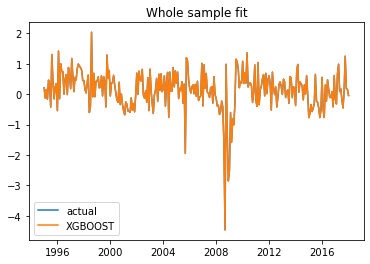

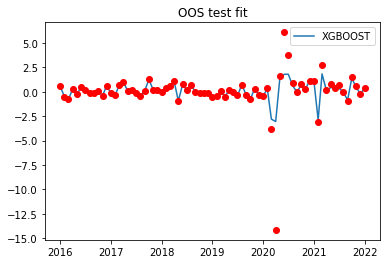

In [9]:
xgpred = regressor.predict(x)
xg_df = pd.DataFrame(xgpred, columns = ['xgfit'], index = df_model.index)

plt.plot(y,label="actual")
plt.plot(xg_df['xgfit'],label="XGBOOST")
plt.legend()
plt.title('Whole sample fit')

df_test = df.loc['2016-1-1':'2022-1-1']
y_test = df_test[target]
x_test = df_test[reglist]

xgpred_test = regressor.predict(x_test)
xg_df_test = pd.DataFrame(xgpred_test, columns = ['xgfit'], index = df_test.index)

plt.figure()
#plt.plot(y_test,label="actual")
plt.plot(xg_df_test,label="XGBOOST")
plt.legend()
plt.title('OOS test fit')
plt.plot(df_test[target], 'ro')

In [ ]:
jnnjnjn

In [13]:
df.to_csv('tester.csv')